In [1]:
import networkx as nx
from glob import glob
import pdb
import re
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd; pd.options.display.float_format = '{:,.2f}'.format
import statsmodels.stats.api as sm
import warnings; warnings.filterwarnings("ignore", category=UserWarning)
from statistics import median_low

In [2]:
import sys
import os

sys.path.extend(['./..'])  # have to add the project path manually to the Python path
os.chdir('./..')

In [3]:
pwd

'/home/danielgonzalez/repos/infinity-mirror'

In [4]:
from src.utils import load_pickle
from src.Tree import TreeNode

In [5]:
%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = [15, 10]

In [7]:
def plot_graph(g, ax=None, prog: str='neato', title=None, sel=None, pos=None, node_color=None, edge_color=None):
#     pos = nx.spring_layout(g)
    pos = nx.nx_agraph.graphviz_layout(g, prog=prog)
    if node_color is None:
        node_color = 'black'
    if edge_color is None:
        edge_color = 'gray'
    plt.rcParams['figure.figsize'] = [5, 5]
    nx.draw_networkx_nodes(g, ax=ax, pos=pos, alpha=0.85, node_size=40, node_color=node_color)
    nx.draw_networkx_edges(g, ax=ax, pos=pos, alpha=0.55, edge_color=edge_color)
    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
#     if title is None:
#         title = g.name
# #     plt.title(title)
    plt.style.use('seaborn-white')
    plt.grid(False)

In [8]:
def grid_plot_v2(tnodes, model, graph_name):
    rows, cols = 10, 5 
    plt.rcParams['figure.figsize'] = [20, 30]
    
    grid = gridspec.GridSpec(rows, cols);
    fig = plt.figure();

    for i, box in enumerate(grid):
        ax = fig.add_subplot(box)
        sel = 'fast'
        g = tnodes[i].graph
        s = str(tnodes[i].stats['deltacon0'])
        plot_graph(g, ax=ax, sel=sel, title=f'{sel[0]} {i+1} {g.order(), g.size()}')
        plt.text(s=s, x=0, y=0)
    plt.tight_layout()
    plt.suptitle(f'{model} {graph_name}', y=1);

In [9]:
def grid_plot(graphs, selections, model, graph_name):
#     rows, cols = 3, n
    rows, cols = 3, n+1 
    plt.rcParams['figure.figsize'] = [10, 5]
    
    grid = gridspec.GridSpec(rows, cols);
    fig = plt.figure();

    for i, box in enumerate(grid):
        ax = fig.add_subplot(box)
        sel = selections[i]
        g = graphs[i]
        plot_graph(g, ax=ax, sel=sel, title=f'{sel[0]}_{i % (n + 1)}_{g.order(), g.size()}')
    plt.tight_layout()
    plt.suptitle(f'{model} {graph_name}', y=1);

In [10]:
base_filename = '/home/danielgonzalez/repos/infinity-mirror/output/pickles'
name = 'clique-ring-25-4'
sel = 'fast'

In [11]:
#trial_id = 40   # which of the 50 different chains to pick
T = 50          # number of chains
N = 20          # length of the chain
n = 3

#selections = ['fast']*(3*(n + 1))
models = 'CNRG', 'HRG', 'Chung-Lu', 'BTER', 'SBM', 'NetGAN', 'GraphVAE'
cols = 'name', 'model', 'sel', 'tid', 'root', 'fail'
tnode_dict = {col: [] for col in cols}
prog = 'neato'

filenames = []
graphs = []

In [12]:
for model in ('CNRG',):
    print('reading', model)
    # for each of the 50 chains
    for tid in range(1, T+1):
        for sel in 'fast',:
            path = f'{base_filename}/{name}/{model}/'
            pattern = fr"{sel}\_{N}\_{tid}(\_\S+)?(\.pkl.gz)"
            found = False
            for file in os.listdir(path):
                if re.fullmatch(pattern, file) is not None:
                    pickle_path = f'{path}{file}'
                    found = True
                    break
            if not found:
                continue 
            fail_iter = float('inf')
            if 'failed' in pickle_path:
                fail_iter = int(pickle_path[pickle_path.rfind('-')+1: pickle_path.find('.pkl.gz')])
#                 print(f'{name}, {model}, fail: {fail_iter}', end=' ', flush=True)
            
            root = load_pickle(pickle_path)
            row = {'name': name, 'model': model, 'sel': sel, 'tid': tid, 'root': root, 'fail': fail_iter}
            for col, val in row.items():
                tnode_dict[col].append(val)
tnode_df = pd.DataFrame(tnode_dict)
tnode_df['height'] = tnode_df.root.apply(lambda root: root.height)
print('done')

reading CNRG
done


In [ ]:
# SKIP THIS
# trial_id = which chain out of 50 to pick
for trial_id in (11, 12, 13):
    for sel in ('fast',):
        path = f'{base_filename}/{name}/{model}/'
        pattern = fr"{sel}\_{N}\_{trial_id}(\_\S+)?(\.pkl.gz)"
        for file in os.listdir(path):
            if re.fullmatch(pattern, file) is not None:
                pickle_path = f'{path}{file}'
                break
        print('reading pickle', pickle_path)
        root = load_pickle(pickle_path)
        root_graphs = [root.graph]
        root_graphs.extend([tnode.graph for tnode in root.descendants[: n]])
        graphs.extend(root_graphs)

grid_plot_v2(tnodes=graphs, model=model, graph_name=name)

In [13]:
# consider the graphs with at least 5 graphs
filtered_tnode_df = tnode_df[tnode_df.height >= 5]

array(['CNRG'], dtype=object)

In [20]:
filtered_tnode_df['dc'] = filtered_tnode_df.root.apply(lambda root: root.descendants[-1].stats['deltacon0'])
filtered_tnode_df['lambda'] = filtered_tnode_df.root.apply(lambda root: root.descendants[-1].stats['lambda_dist'])
filtered_tnode_df['dc_seq'] = filtered_tnode_df.root.apply(lambda root: root.descendants[-1].stats_seq['deltacon0'])
filtered_tnode_df['lambda_seq'] = filtered_tnode_df.root.apply(lambda root: root.descendants[-1].stats_seq['lambda_dist'])
filtered_tnode_df.model.unique()

array(['CNRG'], dtype=object)

In [21]:
filtered_tnode_df
#filtered_tnode_df.root[0].children[0].stats

,name,model,sel,tid,root,fail,height,dc,dc_seq,lambda_seq,lambda
0,clique-ring-25-4,CNRG,fast,1,root,inf,20,441.61,500.53,0.00,0.00
1,clique-ring-25-4,CNRG,fast,2,root,inf,20,444.35,453.19,0.00,0.00
2,clique-ring-25-4,CNRG,fast,3,root,inf,20,414.46,459.61,0.00,0.00
3,clique-ring-25-4,CNRG,fast,4,root,inf,20,416.94,527.27,0.00,0.00
4,clique-ring-25-4,CNRG,fast,5,root,inf,20,423.56,456.60,0.00,0.00
5,clique-ring-25-4,CNRG,fast,6,root,inf,20,426.59,475.64,0.00,0.00
6,clique-ring-25-4,CNRG,fast,7,root,inf,20,407.18,459.25,0.00,0.00
7,clique-ring-25-4,CNRG,fast,8,root,inf,20,419.32,461.82,0.00,0.00
8,clique-ring-25-4,CNRG,fast,9,root,inf,20,466.00,519.05,0.00,0.00
9,clique-ring-25-4,CNRG,fast,10,root,inf,20,412.09,455.41,0.00,0.00


In [ ]:
sel = 'fast'
median_tnodes = {}
for model, group in filtered_tnode_df.groupby('model'):  # pick the median 
    med = median_low(group.dc.values)
    row = group[group.dc==med].head(1)
    median_tnodes[model] = row.root.values[0]

median_graphs = {}
for model, root in median_tnodes.items():
    g1 = root.descendants[0].graph
    g5 = root.descendants[4].graph
    if root.height < 20:
        g20 = nx.empty_graph()
    else:
        g20 = root.descendants[19].graph
    
    median_graphs[model] = (g1, g5, g20)

In [ ]:
node_colors = '#96C93C', '#F6971F', '#674099'
gnames = '1', '5', '20'
for model, graphs in median_graphs.items():
    for g, color, gname in zip(graphs, node_colors, gnames):
        plot_graph(g, node_color=color, edge_color='gray')
#         plt.savefig(f'./output/median-graphs/{name}/{model}-{gname}.svg', transparent=True, bbox_inches='tight')
#         plt.close()


In [ ]:
#base_filename = './output/pickles'
# name = 'clique-ring-25-4'


name = 'grid-10-10'
# model = 'GraphVAE'
model = 'SBM'
N = 20
print(name, model)
selections = ['fast']*50 #(3 * (n+1))
tnodes = {1: [], 5: [], 20: []}
prog = 'neato'
filenames = []

for trial_id in range(1, 51):
    for gen in (1, 5, 20):
        for sel in ('fast',):
            path = f'{base_filename}/{name}/{model}/'
            pattern = fr"{sel}\_{N}\_{trial_id}(\_\S+)?(\.pkl.gz)"

            found = False
            for file in os.listdir(path):
                if re.fullmatch(pattern, file) is not None:
                    pickle_path = f'{path}{file}'
                    found = True
                    break
            
            if not found:
                continue
            if trial_id % 10 == 0:
                print('reading pickle', pickle_path, end=' ', flush=True)
            root = load_pickle(pickle_path)
            if gen == 0:
                tnode = root
            else:
                tnode = root.descendants[gen - 1]
            tnodes[gen].append(tnode)


In [ ]:
# get median for the 1, 5, and 20 gens
median_tnode = {}
for key, tnode in tnodes.items():
    median_tnode[key] = sorted(tnode, key=lambda x: x.stats['deltacon0'])[24]

for key, med_tn in median_tnode.items():
    g = med_tn.graph
    g = nx.Graph(g)
    g = nx.convert_node_labels_to_integers(g)
    for n, d in g.nodes(data=True):
        if 'assigned_deg' in d:
            del d['assigned_deg']
    nx.write_gml(g, f'/home/danielgonzalez/repos/infinity-mirror/output/gmls/{name}/{model}-{key}.gml')

In [ ]:
grid_plot_v2(tnodes[1], model, name)

In [ ]:
median_tnode

In [ ]:
sorted_tnodes_20 = sorted(tnodes[20], key=lambda x: x.stats['deltacon0'])

In [ ]:
sorted_tnodes_20[0], sorted_tnodes_20[-1]

In [ ]:
print(nx.__version__)

In [ ]:
nx.write_gml(sorted_tnodes_20[24].graph, f'/home/danielgonzalez/repos/infinity-mirror/output/gmls/{name}/{model}_20_median.gml')
print('hi')

tnodes

## Aggregate all the stats make the plot

1. Reading info from pickles

In [25]:
def get_stats_from_root(name, model, sel, root, cols, trial_id):
    
    for tnode in root.descendants:
        row = {}
        row['name'] = name
        
        row['orig_n'] = root.graph.order()
        row['orig_m'] = root.graph.size()
        row['orig_graph_obj'] = root.graph
        
        row['model'] = model
        row['sel'] = sel
        row['trial_id'] = trial_id
        
        row['gen_id'] = tnode.depth
        row['gen_n'] = tnode.graph.order()
        row['gen_m'] = tnode.graph.size()
        row['gen_graph_obj'] = tnode.graph
        
        stats = tnode.stats_seq
        assert set(cols[-8: ]) == set(stats.keys()), f'tnode: {stats.keys()} doesnt have all the reqd stats'
        for key, val in stats.items():
            row[key] = val
        
        assert len(row.keys()) == len(cols), \
        f'Imporper number of cols in row: {len(row)}: expected {len(cols)} {stats.keys()}'
        
        yield row
    

In [23]:
def analyze_failures(name, model, sel):
    """
    Analyze the failed pickles
    """
    base_filename = './output/pickles'
    fail_counts = 0
    N = 20
    n = 0
    for file in glob(f'{base_filename}/{name}/{model}/{sel}*'):
        n += 1
        if 'failed' in file:
            fail_counts += 1
            good_id = int(file[file.rfind('-')+1: file.find('.pkl.gz')])
            print(good_id, end=' ', flush=True)
    print()
    print('{} / {} fails'.format(fail_counts, n))

In [ ]:
analyze_failures(name='BA-100-3', model='NetGAN', sel='fast')

In [29]:
base_filename = '/home/danielgonzalez/repos/infinity-mirror/output/pickles'
# name = 'grid-10-10'
name = 'clique-ring-25-4'

N = 20  # number of total time steps
T = 50  # number of trials

cols = ['name', 'orig_n', 'orig_m', 'orig_graph_obj', 
        'model', 'sel', 'trial_id',
        'gen_id', 'gen_n', 'gen_m', 'gen_graph_obj',
        'deltacon0', 'lambda_dist', 'cvm_degree', 'cvm_pagerank', 
        'pgd_pearson', 'pgd_spearman', 'node_diff', 'edge_diff']

data = {col: [] for col in cols}

fail_count = 0

#for model in ('CNRG', 'SBM', 'Chung-Lu', 'BTER', 'Erdos-Renyi', 'GraphAE', 'GraphVAE')[: 2]:
for model in ('CNRG',):
    for sel in 'fast',:
        for trial_id in range(1, T+1):
            path_re = f'{base_filename}/{name}/{model}/{sel}_{N}_{trial_id}.pkl.gz'
            try:
                root_pickle_path = glob(path_re)[0]
            except IndexError:
                print(f'skipping {model}')
                continue
            print('reading ', '/'.join(root_pickle_path.split('/')[-2:]), end=' ', flush=True)

            if 'failed' in root_pickle_path:
                print(f'Infinity mirror failed for {root_pickle_path}! Skipping')
                fail_count += 1
                continue

            root = load_pickle(root_pickle_path)
            for row in get_stats_from_root(name=name, model=model, sel=sel, root=root, 
                                        cols=cols, trial_id=trial_id):
                for col, val in row.items():
                    data[col].append(val)

df = pd.DataFrame(data)

reading  CNRG/fast_20_1.pkl.gz reading  CNRG/fast_20_2.pkl.gz reading  CNRG/fast_20_3.pkl.gz reading  CNRG/fast_20_4.pkl.gz reading  CNRG/fast_20_5.pkl.gz reading  CNRG/fast_20_6.pkl.gz reading  CNRG/fast_20_7.pkl.gz reading  CNRG/fast_20_8.pkl.gz reading  CNRG/fast_20_9.pkl.gz reading  CNRG/fast_20_10.pkl.gz reading  CNRG/fast_20_11.pkl.gz reading  CNRG/fast_20_12.pkl.gz reading  CNRG/fast_20_13.pkl.gz reading  CNRG/fast_20_14.pkl.gz reading  CNRG/fast_20_15.pkl.gz reading  CNRG/fast_20_16.pkl.gz reading  CNRG/fast_20_17.pkl.gz reading  CNRG/fast_20_18.pkl.gz reading  CNRG/fast_20_19.pkl.gz reading  CNRG/fast_20_20.pkl.gz reading  CNRG/fast_20_21.pkl.gz reading  CNRG/fast_20_22.pkl.gz reading  CNRG/fast_20_23.pkl.gz reading  CNRG/fast_20_24.pkl.gz reading  CNRG/fast_20_25.pkl.gz reading  CNRG/fast_20_26.pkl.gz reading  CNRG/fast_20_27.pkl.gz reading  CNRG/fast_20_28.pkl.gz reading  CNRG/fast_20_29.pkl.gz reading  CNRG/fast_20_30.pkl.gz reading  CNRG/fast_20_31.pkl.gz reading  CNRG/fas

In [30]:
df.head()

,name,orig_n,orig_m,orig_graph_obj,model,sel,trial_id,gen_id,gen_n,gen_m,gen_graph_obj,deltacon0,lambda_dist,cvm_degree,cvm_pagerank,pgd_pearson,pgd_spearman,node_diff,edge_diff
0,clique-ring-25-4,100,175,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",CNRG,fast,1,1,100,175,"(18, 19, 20, 21, 47, 55, 22, 23, 24, 25, 54, 8...",415.24,0.00,0.00,0.06,inf,inf,0.00,0.00
1,clique-ring-25-4,100,175,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",CNRG,fast,1,2,100,175,"(14, 15, 16, 17, 31, 67, 18, 19, 20, 21, 53, 3...",456.12,0.00,0.00,0.01,inf,inf,0.00,0.00
2,clique-ring-25-4,100,175,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",CNRG,fast,1,3,100,175,"(16, 17, 18, 19, 122, 134, 20, 21, 22, 23, 57,...",460.55,0.00,0.00,0.00,inf,inf,0.00,0.00
3,clique-ring-25-4,100,175,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",CNRG,fast,1,4,100,175,"(15, 16, 17, 18, 40, 45, 19, 20, 21, 22, 86, 7...",463.33,0.00,0.00,0.01,inf,inf,0.00,0.00
4,clique-ring-25-4,100,175,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",CNRG,fast,1,5,100,175,"(16, 17, 18, 19, 40, 54, 20, 21, 22, 23, 55, 5...",473.52,0.00,0.00,0.01,inf,inf,0.00,0.00


In [31]:
df[(df.name=='clique-ring-25-4') & (df.model=='CNRG') & (df.gen_id==5)].shape

(50, 19)

In [42]:
def group_plot(df):
    name = df.name.unique()[0]
    metrics = ['node_diff', 'edge_diff', 'lambda_dist', 'deltacon0', 'cvm_degree']#, 'pgd_spearman']
    rows = len(metrics)
    models = df.model.unique() # ['CNRG', 'SBM', 'Chung-Lu', 'BTER']
    cols = len(models)

    n_d_min = min(df[df.model==model].node_diff.min() for model in models) - 1
    n_d_max = max(df[df.model==model].node_diff.max() for model in models) + 5
    
    e_d_min = min(df[df.model==model].edge_diff.min() for model in models) - 1
    e_d_max = max(df[df.model==model].edge_diff.max() for model in models) + 5
    
    l_d_min = min(df[df.model==model].lambda_dist.min() for model in models) - 0.1
    l_d_max = max(df[df.model==model].lambda_dist.max() for model in models) + 0.15
    
    dc0_min = min(df[df.model==model].deltacon0.min() for model in models) - 100
    dc0_max = max(df[df.model==model].deltacon0.max() for model in models) + 100
    
    p_sp_min = min(df[df.model==model].pgd_spearman.min() for model in models) - 0.1
    p_sp_max = max(df[df.model==model].pgd_spearman.max() for model in models) + 0.15
    
    d_min = min(df[df.model==model].cvm_degree.min() for model in models) - 0.1
    d_max = max(df[df.model==model].cvm_degree.max() for model in models) + 0.15

    plt.rcParams['figure.figsize'] = [15, 10]
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True)
    print(rows, cols)

    for i in range(rows):
        for j in range(cols):
            # changed because rows=5 but cols=1 so axes.shape=(5,)
            # ax = axes[i, j]
            ax = axes[i]
            metric = metrics[i]
            model = models[j]
            filtered_df = df[df.model==model]
            
            if i == 0 and j == 0:
                legend_style = 'brief'
            else:
                legend_style = ''
            
            sns.lineplot(x='gen_id', y=metric, ax=ax, data=filtered_df, 
                         hue='sel', marker='o', ci=99, err_style='band', legend=legend_style);
            
            if metric == 'node_diff':
                ax.set_ylim((n_d_min, n_d_max))
            elif metric == 'edge_diff':
                ax.set_ylim((e_d_min, e_d_max))
            elif metric == 'lambda_dist':
                ax.set_ylim((l_d_min, l_d_max))
            elif metric == 'deltacon0':
                ax.set_ylim((dc0_min, dc0_max))
            elif metric == 'pgd_spearman':
                ax.set_ylim((p_sp_min, p_sp_max))
            elif metric == 'cvm_degree':
                ax.set_ylim((d_min, d_max))
                
            if j == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')
                
            if i == 0:
                ax.set_title(model)
            else:
                ax.set_title('')
                
            if i == rows - 1:
                ax.set_xlabel('gen_id')
            else:
                ax.set_xlabel('')
            
    plt.suptitle(f'{name}', y=1.01);
    plt.tight_layout()

5 1


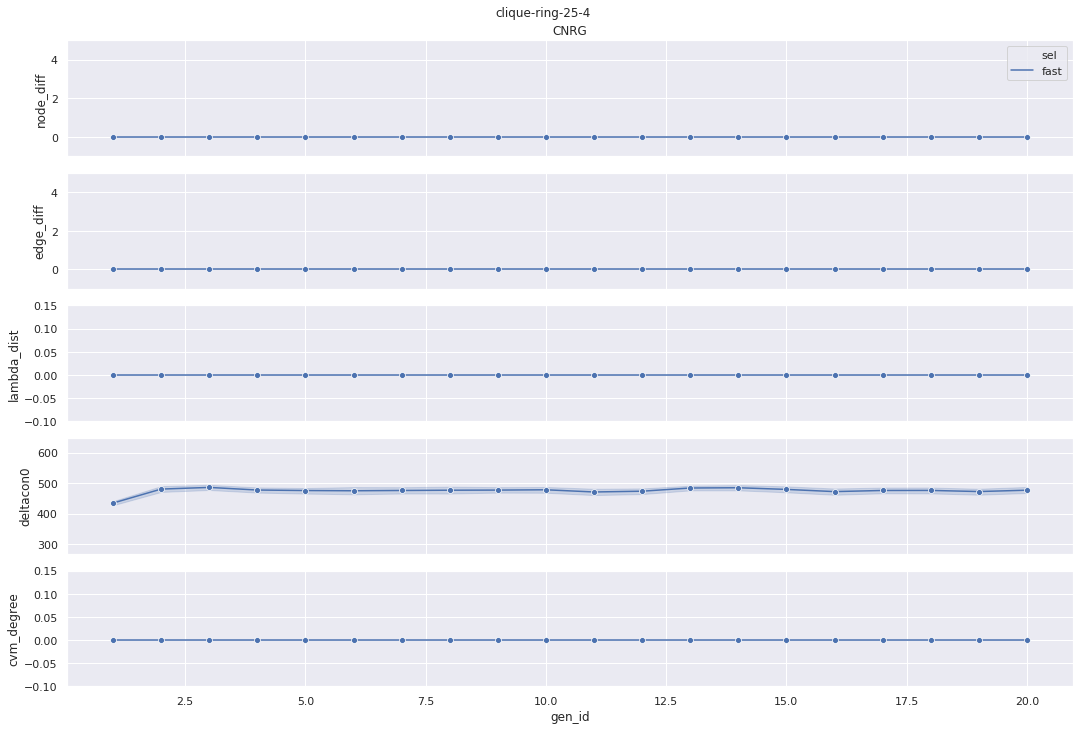

In [43]:
group_plot(df)

## pick the best representatives across trials